# Structure Learning

## Set sys vars

In [1]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['C:\\Users\\Roman\\Desktop\\GitBamt\\BAMT', 'C:\\Users\\Roman\\Desktop\\GitBamt', 'C:\\Users\\Roman\\Desktop\\GitBamt\\BAMT\\tutorials']


## Import modules

In [2]:
%%time
%matplotlib inline
import BAMT.Networks as Nets
import BAMT.Preprocessors as pp

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

Wall time: 5 s


## Preprocessing

In [3]:
hack = pd.read_csv(r'../Data/hack_processed_with_rf.csv')

In [4]:
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
hack = hack[cols]

In [5]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(hack)

## Initializing Bayessian Network

<p> There are 3 type of Bayessian Networks - DiscreteBN, ContinuousBN, HybridBN. <br>
Note that if you pass discrete data to Continoust BN, you get an error.<br><br>
For ContinousBN user can choose whether use mixture nodes or not, for Hybrid user can restrict/allow using logit/mixture nodes.<p> 

In [6]:
bn = Nets.HybridBN(has_logit=True, use_mixture=True) # init BN
info = p.info # mapping of nodes (Dict["types": Dict[node_name: type], "signs": Dict[node_name: sign]])

In [7]:
bn.add_nodes(info)
bn.add_edges(discretized_data, scoring_function=('MI',)) # use mutual information sf implemented in BAMT

In [8]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,ConditionalLogit,disc,"[Depth, Structural setting, Lithology]","[cont, disc, disc]"
2,Lithology,ConditionalLogit,disc,"[Netpay, Structural setting]","[cont, disc]"
3,Structural setting,Logit,disc,[Permeability],[cont]
4,Gross,MixtureGaussian,cont,[Porosity],[cont]
5,Netpay,MixtureGaussian,cont,[Permeability],[cont]
6,Porosity,ConditionalMixtureGaussian,cont,[Tectonic regime],[disc]
7,Permeability,MixtureGaussian,cont,[Gross],[cont]
8,Depth,MixtureGaussian,cont,[Gross],[cont]


In [9]:
bn.plot('Test1')

2022-01-12 14:47:17,979 | ERROR    | Networks.py-plot-0207 | This version allows only html format.


In [10]:
# Now let's plot graph
bn.plot('Simple.html')

## Parameters in structure learning

<p> There are 4 parameters user can tune: init_nodes, init_edges, white_list, remove_init_edges. <p>

### Init_nodes

This one defines root nodes (thus they haven't parents at all).

In [11]:
print(bn.nodes)

[Tectonic regime, Period, Lithology, Structural setting, Gross, Netpay, Porosity, Permeability, Depth]


In [12]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross']}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('init_nodes.html')

### Init_edges

<p> This one defines edges from which learning procedure starts <p>

In [13]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
          'init_edges':[('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')],}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('init_edges.html')

### white_list

Strictly set edges where algoritm must learn

In [14]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
         'white_list': [('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')]}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('whihe_list.html')

### Remove_init_edges

Allow algorithm to remove edges defined by user.

In [15]:
params = {'init_nodes': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross'],
          'init_edges':[('Period', 'Permeability'), ('Structural setting', 'Netpay'), ('Gross', 'Permeability')],
         'remove_init_edges':True}
bn.add_edges(discretized_data, scoring_function=('MI',), params=params)
bn.plot('remove_init.html')

## Parameters Learning

<p> The second stage of learning is related to parameters, user should call fit_parameters method. <br>
    In this procedure each vertex calls its own parameters_learning method and write down an outcome into distributions in bayessian network object. <br><br>

What is going on inside each type of vertex can be found in special notebook ("Nodes.ipynb") <p>

In [16]:
bn.sample(10) # no way to sample from parametrically unfitted network 

2022-01-12 14:47:22,746 | ERROR    | Networks.py-sample-0175 | Parameter learning wasn't done. Call fit_parameters method


Let's train two networks and compare their results.

In [17]:
bn_1 = Nets.HybridBN(has_logit=True, use_mixture=True)
d = p.info
bn_1.add_nodes(d)

In [18]:
bn_2 = Nets.HybridBN(has_logit=True, use_mixture=True)
d = p.info
bn_2.add_nodes(d)

In [19]:
from pgmpy.estimators import K2Score
bn_1.add_edges(discretized_data, scoring_function=('MI',))
bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [20]:
%%time
bn_1.fit_parameters(hack)

Wall time: 18.3 s


In [21]:
%%time
bn_2.fit_parameters(hack)

Wall time: 40.1 s


In [22]:
predictions_mi = bn_1.sample(514, as_df=True)
predictions_k2 = bn_2.sample(514, as_df=True)

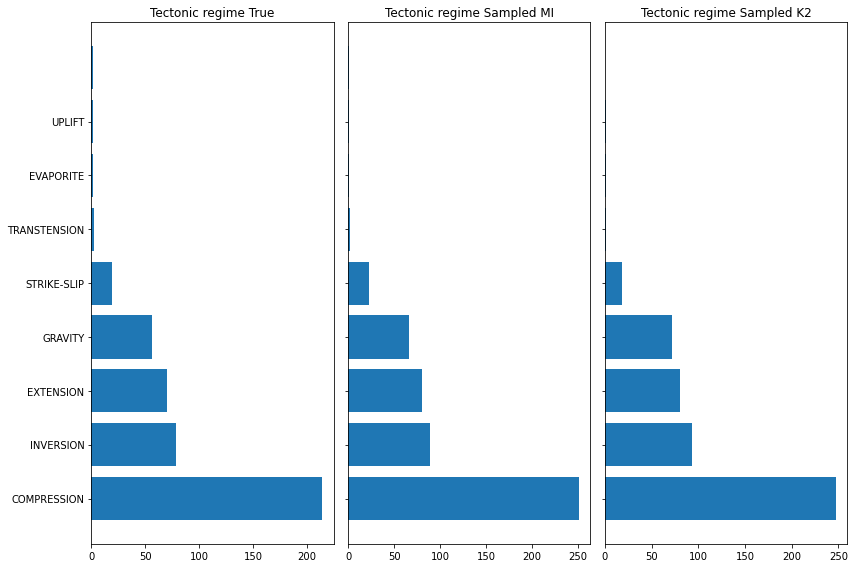

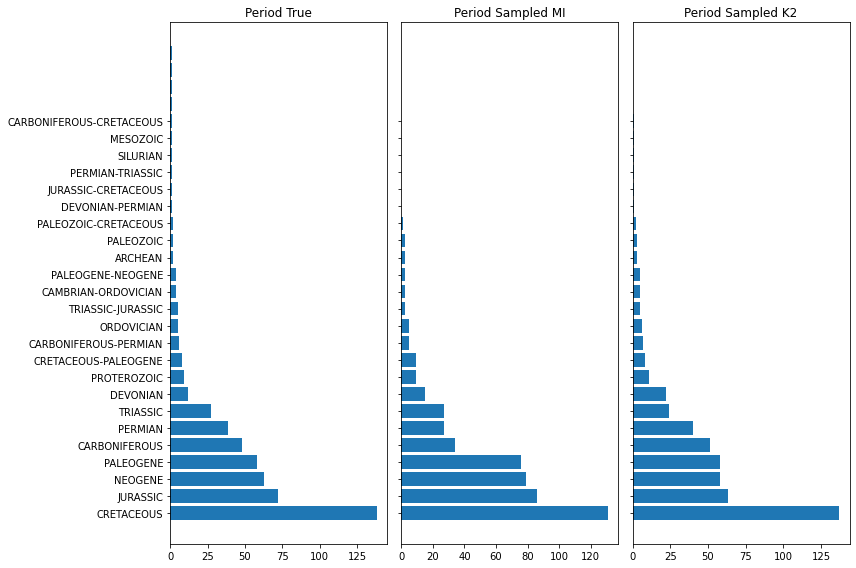

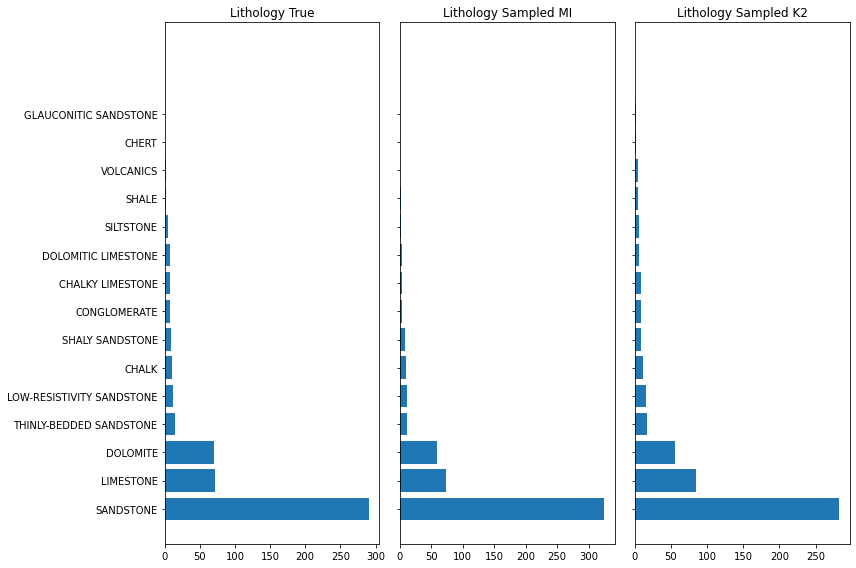

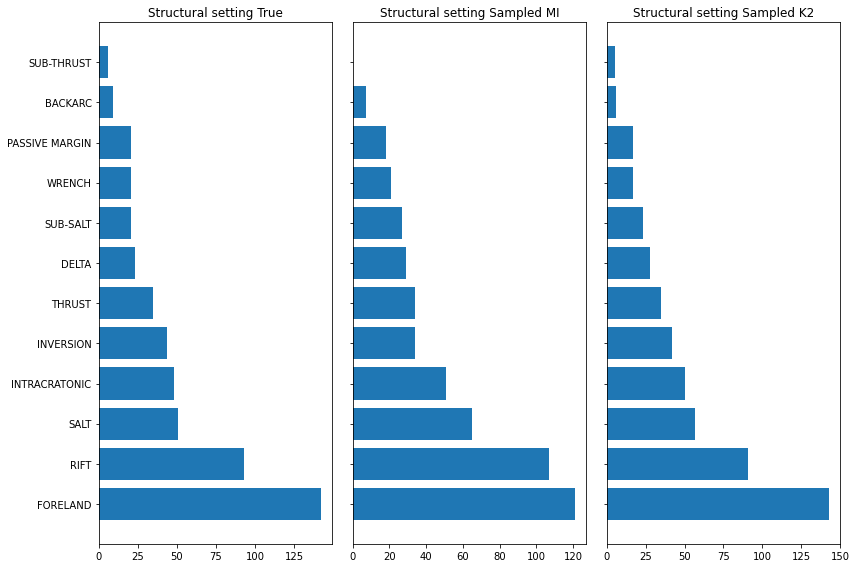

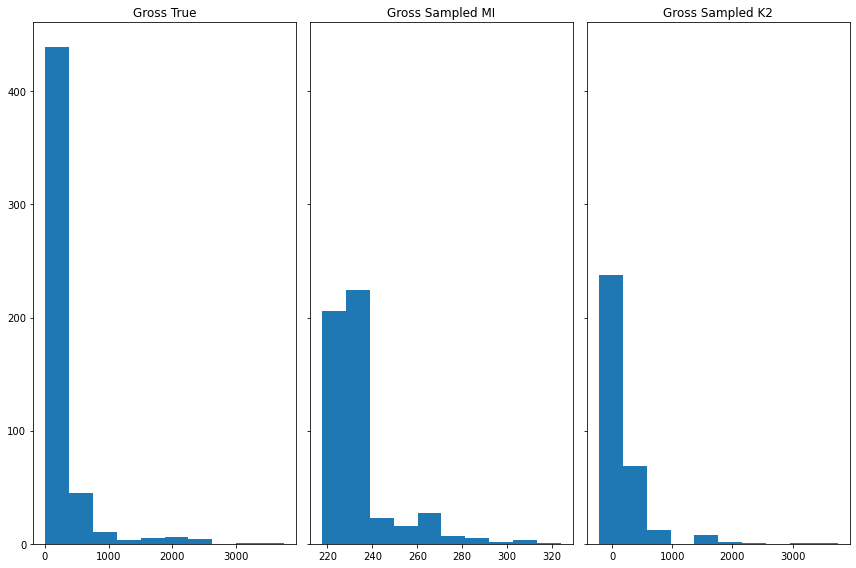

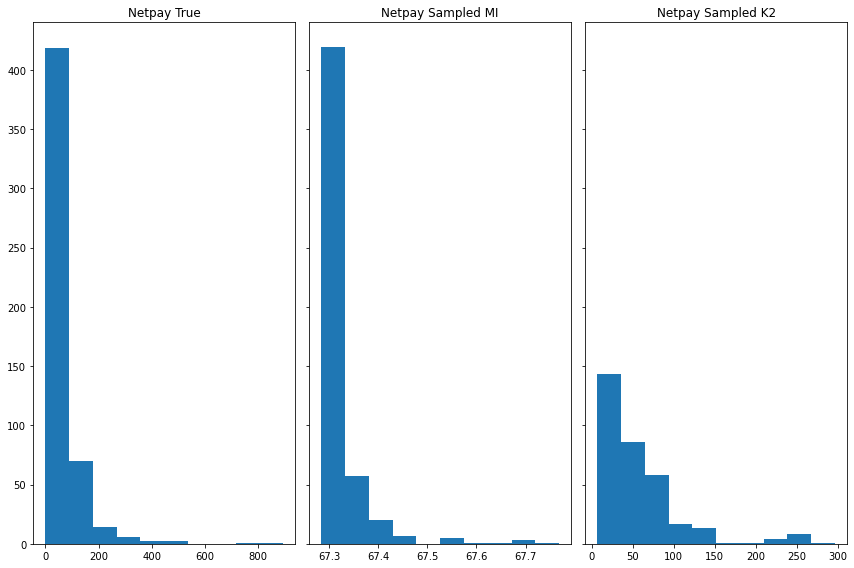

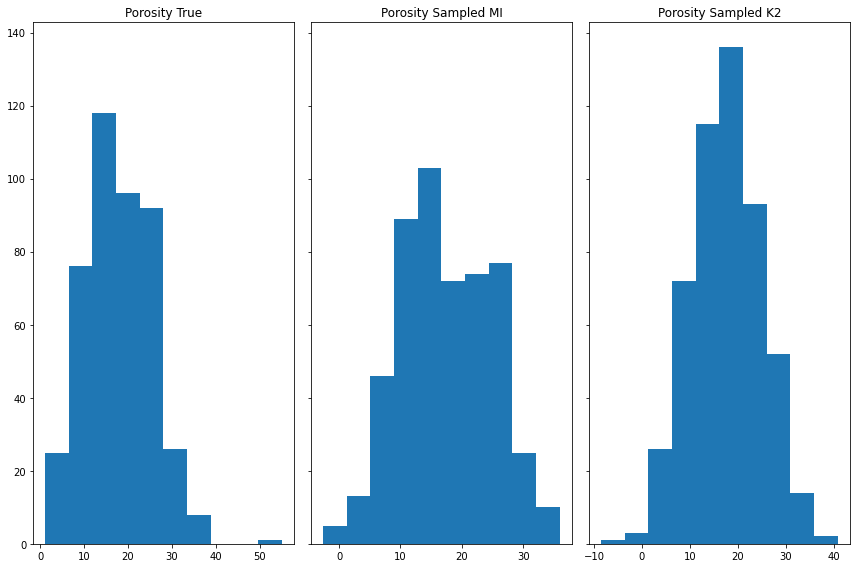

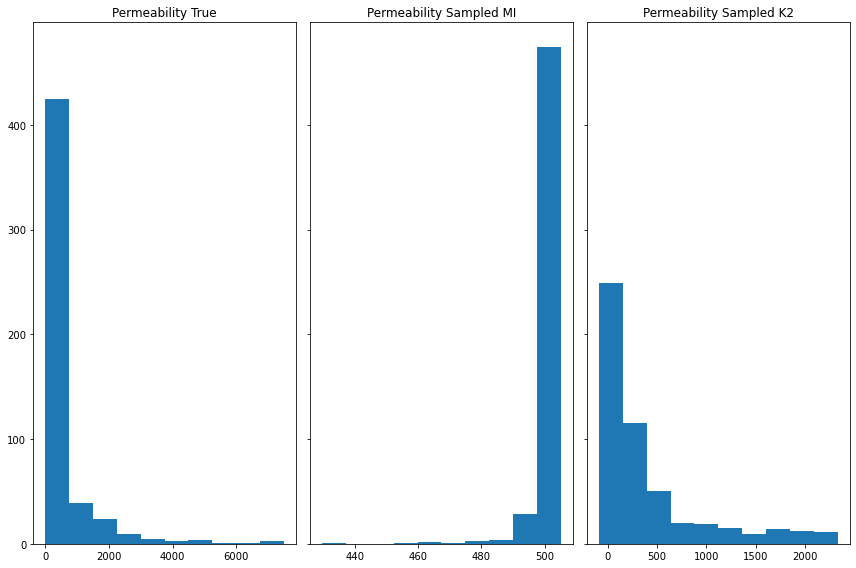

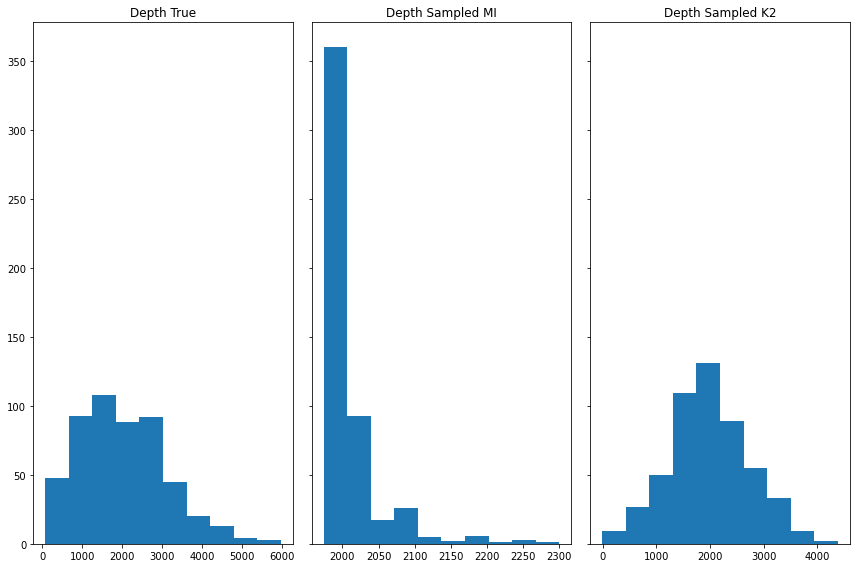

In [23]:
for column in hack.columns.to_list():
    fig, ax = plt.subplots(1,3, figsize=(12,8), sharey=True)
    if hack[column].dtype.name in ['float64']:
        ax[0].hist(hack[column].values)
        ax[1].hist(predictions_mi[column].values)
        ax[2].hist(predictions_k2[column].values)
    else:
        ax[0].barh(hack[column].value_counts().index, hack[column].value_counts().values)
        ax[1].barh(predictions_mi[column].value_counts().index, predictions_mi[column].value_counts().values)
        ax[2].barh(predictions_k2[column].value_counts().index, predictions_k2[column].value_counts().values)
    ax[0].set_title(f'{column} True')
    ax[1].set_title(f'{column} Sampled MI')
    ax[2].set_title(f"{column} Sampled K2")
    
    plt.tight_layout()